# Axisymmetric rotor

This notebook demonstrates the process of running a Workbench service on a local machine to solve both 2D general axisymmetric rotor and 3D rotor models using PyMechanical. 
It includes steps for uploading project files, executing scripts, downloading results, and displaying output images.

In [1]:
import os
import pathlib

In [2]:
from ansys.workbench.core import launch_workbench
from ansys.mechanical.core import launch_mechanical

Launch the Workbench service on the local machine using specific options.
Define the working directory and subdirectories for assets, scripts, and geometry databases (agdb).
The `launch_workbench` function starts a Workbench session with the specified directories.

In [3]:
workdir = pathlib.Path("__file__").parent
assets = workdir / "assets"
scripts = workdir / "scripts"
agdb = workdir / "agdb"

In [4]:
wb = launch_workbench(release="241", server_workdir=str(workdir.absolute()), client_workdir=str(workdir.absolute()))

Upload the project files to the server using the `upload_file` method.
The files uploaded are `axisymmetric_model.agdb`, `rotor_3d_model.agdb`, `axisymmetric_rotor.py`, and `rotor_3d.py`.

In [5]:
wb.upload_file(str(agdb / "axisymmetric_model.agdb"))
wb.upload_file(str(agdb / "rotor_3d_model.agdb"))
wb.upload_file(str(scripts / "axisymmetric_rotor.py"))
wb.upload_file(str(scripts / "rotor_3d.py"))

Uploading axisymmetric_model.agdb:   0%|          | 0.00/2.52M [00:00<?, ?B/s]

Uploading axisymmetric_model.agdb: 100%|██████████| 2.52M/2.52M [00:00<00:00, 170MB/s]

Uploading rotor_3d_model.agdb:   0%|          | 0.00/2.52M [00:00<?, ?B/s]

Uploading rotor_3d_model.agdb: 100%|██████████| 2.52M/2.52M [00:00<00:00, 84.7MB/s]

Uploading axisymmetric_rotor.py:   0%|          | 0.00/24.4k [00:00<?, ?B/s]

Uploading axisymmetric_rotor.py: 100%|██████████| 24.4k/24.4k [00:00<00:00, 1.55MB/s]

Uploading rotor_3d.py:   0%|          | 0.00/23.0k [00:00<?, ?B/s]

Uploading rotor_3d.py: 100%|██████████| 23.0k/23.0k [00:00<00:00, 1.51MB/s]

Execute a Workbench script (`project.wbjn`) to define the project and load the geometry.
The log file is set to `wb_log_file.log` and the name of the system created is stored in `sys_name` and printed.

In [6]:
export_path = 'wb_log_file.log'
wb.set_log_file(export_path)
sys_name = wb.run_script_file(str((assets / "project.wbjn").absolute()), log_level='info')
print(sys_name)

['SYS', 'SYS 4']


Start a PyMechanical server for the system and create a PyMechanical client session to solve the 2D general axisymmetric rotor model.
The project directory is printed to verify the connection.

In [7]:
server_port = wb.start_mechanical_server(system_name=sys_name[1])
mechanical = launch_mechanical(start_instance=False, ip='localhost', port=server_port)

In [8]:
print(mechanical.project_directory)

C:\Users\ansys\AppData\Local\Temp\WB_ansys_11708_2\wbnew_files\


Read and execute the script `axisymmetric_rotor.py` via the PyMechanical client to mesh and solve the 2D general axisymmetric rotor model.
The output of the script is printed.

In [9]:
with open(scripts / "axisymmetric_rotor.py") as sf:
    mech_script = sf.read()
mech_output = mechanical.run_python_script(mech_script)
print(mech_output)

{"Total Deformation": "0.79262294403210676 [mm]", "Total Deformation 2": "0.93934788182426 [mm]"}


Specify the Mechanical directory for the Modal Campbell Analysis and fetch the working directory path.
Download the solver output file (`solve.out`) from the server to the client's current working directory and print its contents.

In [10]:
mechanical.run_python_script(f"solve_dir=ExtAPI.DataModel.AnalysisList[2].WorkingDir")
result_solve_dir_server = mechanical.run_python_script(f"solve_dir")
print(f"All solver files are stored on the server at: {result_solve_dir_server}")

All solver files are stored on the server at: C:\Users\ansys\AppData\Local\Temp\WB_ansys_11708_2\wbnew_files\dp0\SYS-6\MECH\


In [11]:
solve_out_path = os.path.join(result_solve_dir_server, "solve.out")

In [12]:
def write_file_contents_to_console(path):
    """Write file contents to console."""
    with open(path, "rt") as file:
        for line in file:
            print(line, end="")

In [13]:
current_working_directory = os.getcwd()
mechanical.download(solve_out_path, target_dir=current_working_directory)
solve_out_local_path = os.path.join(current_working_directory, "solve.out")
write_file_contents_to_console(solve_out_local_path)
os.remove(solve_out_local_path)


 Ansys Mechanical Enterprise                       


 *------------------------------------------------------------------*
 |                                                                  |
 |   W E L C O M E   T O   T H E   A N S Y S (R)  P R O G R A M     |
 |                                                                  |
 *------------------------------------------------------------------*




 ***************************************************************
 *         ANSYS MAPDL 2024 R1          LEGAL NOTICES          *
 ***************************************************************
 *                                                             *
 * Copyright 1971-2024 Ansys, Inc.  All rights reserved.       *
 * Unauthorized use, distribution or duplication is            *
 * prohibited.                                                 *
 *                                                             *
 * Ansys is a registered trademark of Ansys, Inc. or its       *
 * sub

Specify the Mechanical directory path for the Modal Campbell Analysis and fetch the image directory path.
Download an image file (`tot_deform_2D.png`) from the server to the client's current working directory and display it using `matplotlib`.

In [14]:
from matplotlib import image as mpimg
from matplotlib import pyplot as plt

In [15]:
mechanical.run_python_script(f"image_dir=ExtAPI.DataModel.AnalysisList[2].WorkingDir")
result_image_dir_server = mechanical.run_python_script(f"image_dir")
print(f"Images are stored on the server at: {result_image_dir_server}")

Images are stored on the server at: C:\Users\ansys\AppData\Local\Temp\WB_ansys_11708_2\wbnew_files\dp0\SYS-6\MECH\


In [16]:
def get_image_path(image_name):
    return os.path.join(result_image_dir_server, image_name)

In [17]:
def display_image(path):
    print(f"Printing {path} using matplotlib")
    image1 = mpimg.imread(path)
    plt.figure(figsize=(15, 15))
    plt.axis("off")
    plt.imshow(image1)
    plt.show()

In [18]:
image_name = "tot_deform_2D.png"
image_path_server = get_image_path(image_name)

Local image path : C:\Users\ansys\actions-runner\_work\pyworkbench-examples\pyworkbench-examples\pyworkbench-examples\doc\source\examples\axisymmetric-rotor\tot_deform_2D.png
Printing C:\Users\ansys\actions-runner\_work\pyworkbench-examples\pyworkbench-examples\pyworkbench-examples\doc\source\examples\axisymmetric-rotor\tot_deform_2D.png using matplotlib


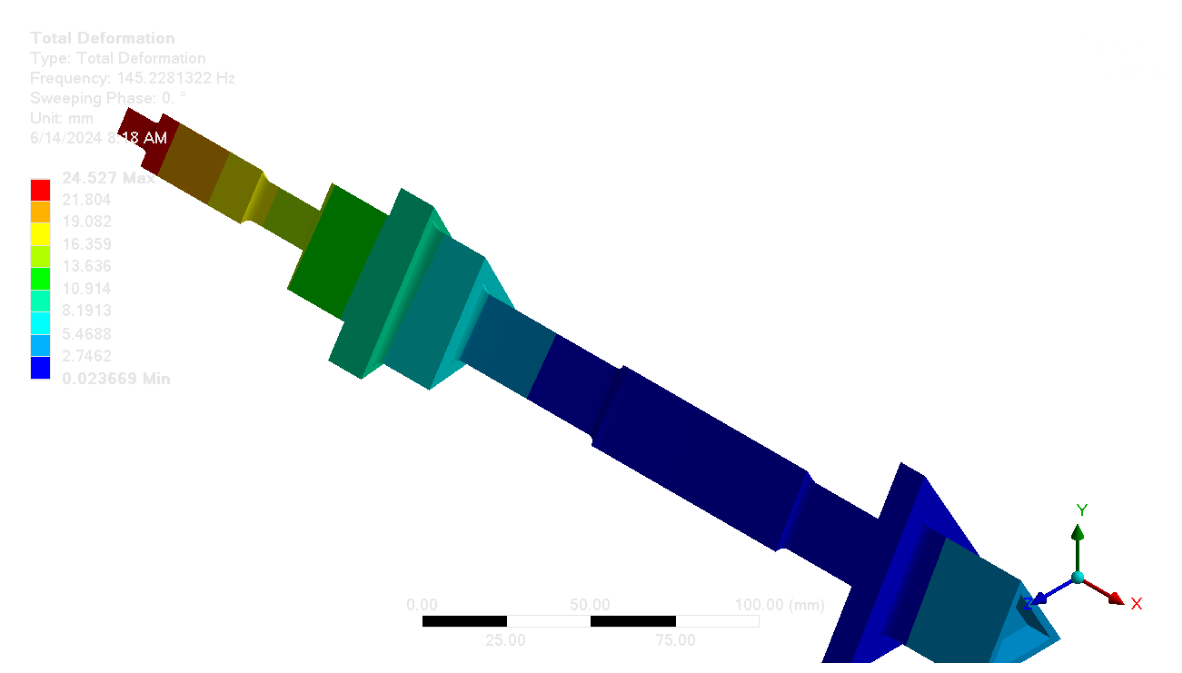

In [19]:
if image_path_server != "":
    current_working_directory = os.getcwd()

    local_file_path_list = mechanical.download(
        image_path_server, target_dir=current_working_directory
    )
    image_local_path = local_file_path_list[0]
    print(f"Local image path : {image_local_path}")
    
    display_image(image_local_path)

Specify the Mechanical directory for the Unbalance Response Analysis and fetch the working directory path.
Download the solver output file (`solve.out`) from the server to the client's current working directory and print its contents.

In [20]:
mechanical.run_python_script(f"solve_dir=ExtAPI.DataModel.AnalysisList[3].WorkingDir")
result_solve_dir_server = mechanical.run_python_script(f"solve_dir")
print(f"All solver files are stored on the server at: {result_solve_dir_server}")

All solver files are stored on the server at: C:\Users\ansys\AppData\Local\Temp\WB_ansys_11708_2\wbnew_files\dp0\SYS-7\MECH\


In [21]:
solve_out_path = os.path.join(result_solve_dir_server, "solve.out")

In [22]:
def write_file_contents_to_console(path):
    """Write file contents to console."""
    with open(path, "rt") as file:
        for line in file:
            print(line, end="")

In [23]:
current_working_directory = os.getcwd()
mechanical.download(solve_out_path, target_dir=current_working_directory)
solve_out_local_path = os.path.join(current_working_directory, "solve.out")
write_file_contents_to_console(solve_out_local_path)
os.remove(solve_out_local_path)


 Ansys Mechanical Enterprise                       


 *------------------------------------------------------------------*
 |                                                                  |
 |   W E L C O M E   T O   T H E   A N S Y S (R)  P R O G R A M     |
 |                                                                  |
 *------------------------------------------------------------------*




 ***************************************************************
 *         ANSYS MAPDL 2024 R1          LEGAL NOTICES          *
 ***************************************************************
 *                                                             *
 * Copyright 1971-2024 Ansys, Inc.  All rights reserved.       *
 * Unauthorized use, distribution or duplication is            *
 * prohibited.                                                 *
 *                                                             *
 * Ansys is a registered trademark of Ansys, Inc. or its       *
 * sub

Start a PyMechanical server for the 3D rotor model system and create a PyMechanical client session.
The project directory is printed to verify the connection.

In [24]:
server_port = wb.start_mechanical_server(system_name=sys_name[0])
mechanical = launch_mechanical(start_instance=False, ip='localhost', port=server_port)

In [25]:
print(mechanical.project_directory)

C:\Users\ansys\AppData\Local\Temp\WB_ansys_11708_2\wbnew_files\


Read and execute the script `rotor_3d.py` via the PyMechanical client to mesh and solve the 3D rotor model.
The output of the script is printed.

In [26]:
with open(scripts / "rotor_3d.py") as sf:
    mech_script = sf.read()
mech_output = mechanical.run_python_script(mech_script)
print(mech_output)

{"Total Deformation": "0.7770134826146281 [mm]", "Total Deformation 2": "0.95766479418025063 [mm]"}


Specify the Mechanical directory for the Modal Campbell Analysis and fetch the working directory path.
Download the solver output file (`solve.out`) from the server to the client's current working directory and print its contents.

In [27]:
mechanical.run_python_script(f"solve_dir=ExtAPI.DataModel.AnalysisList[2].WorkingDir")
result_solve_dir_server = mechanical.run_python_script(f"solve_dir")
print(f"All solver files are stored on the server at: {result_solve_dir_server}")

All solver files are stored on the server at: C:\Users\ansys\AppData\Local\Temp\WB_ansys_11708_2\wbnew_files\dp0\SYS-2\MECH\


In [28]:
solve_out_path = os.path.join(result_solve_dir_server, "solve.out")

In [29]:
def write_file_contents_to_console(path):
    """Write file contents to console."""
    with open(path, "rt") as file:
        for line in file:
            print(line, end="")

In [30]:
current_working_directory = os.getcwd()
mechanical.download(solve_out_path, target_dir=current_working_directory)
solve_out_local_path = os.path.join(current_working_directory, "solve.out")
write_file_contents_to_console(solve_out_local_path)
os.remove(solve_out_local_path)


 Ansys Mechanical Enterprise                       


 *------------------------------------------------------------------*
 |                                                                  |
 |   W E L C O M E   T O   T H E   A N S Y S (R)  P R O G R A M     |
 |                                                                  |
 *------------------------------------------------------------------*




 ***************************************************************
 *         ANSYS MAPDL 2024 R1          LEGAL NOTICES          *
 ***************************************************************
 *                                                             *
 * Copyright 1971-2024 Ansys, Inc.  All rights reserved.       *
 * Unauthorized use, distribution or duplication is            *
 * prohibited.                                                 *
 *                                                             *
 * Ansys is a registered trademark of Ansys, Inc. or its       *
 * sub

Specify the Mechanical directory path for the Modal Campbell Analysis and fetch the image directory path.
Download an image file (`tot_deform_3D.png`) from the server to the client's current working directory and display it using `matplotlib`.

In [31]:
from matplotlib import image as mpimg
from matplotlib import pyplot as plt

In [32]:
mechanical.run_python_script(f"image_dir=ExtAPI.DataModel.AnalysisList[2].WorkingDir")
result_image_dir_server = mechanical.run_python_script(f"image_dir")
print(f"Images are stored on the server at: {result_image_dir_server}")

Images are stored on the server at: C:\Users\ansys\AppData\Local\Temp\WB_ansys_11708_2\wbnew_files\dp0\SYS-2\MECH\


In [33]:
def get_image_path(image_name):
    return os.path.join(result_image_dir_server, image_name)

In [34]:
def display_image(path):
    print(f"Printing {path} using matplotlib")
    image1 = mpimg.imread(path)
    plt.figure(figsize=(15, 15))
    plt.axis("off")
    plt.imshow(image1)
    plt.show()

In [35]:
image_name = "tot_deform_3D.png"
image_path_server = get_image_path(image_name)

Local image path : C:\Users\ansys\actions-runner\_work\pyworkbench-examples\pyworkbench-examples\pyworkbench-examples\doc\source\examples\axisymmetric-rotor\tot_deform_3D.png
Printing C:\Users\ansys\actions-runner\_work\pyworkbench-examples\pyworkbench-examples\pyworkbench-examples\doc\source\examples\axisymmetric-rotor\tot_deform_3D.png using matplotlib


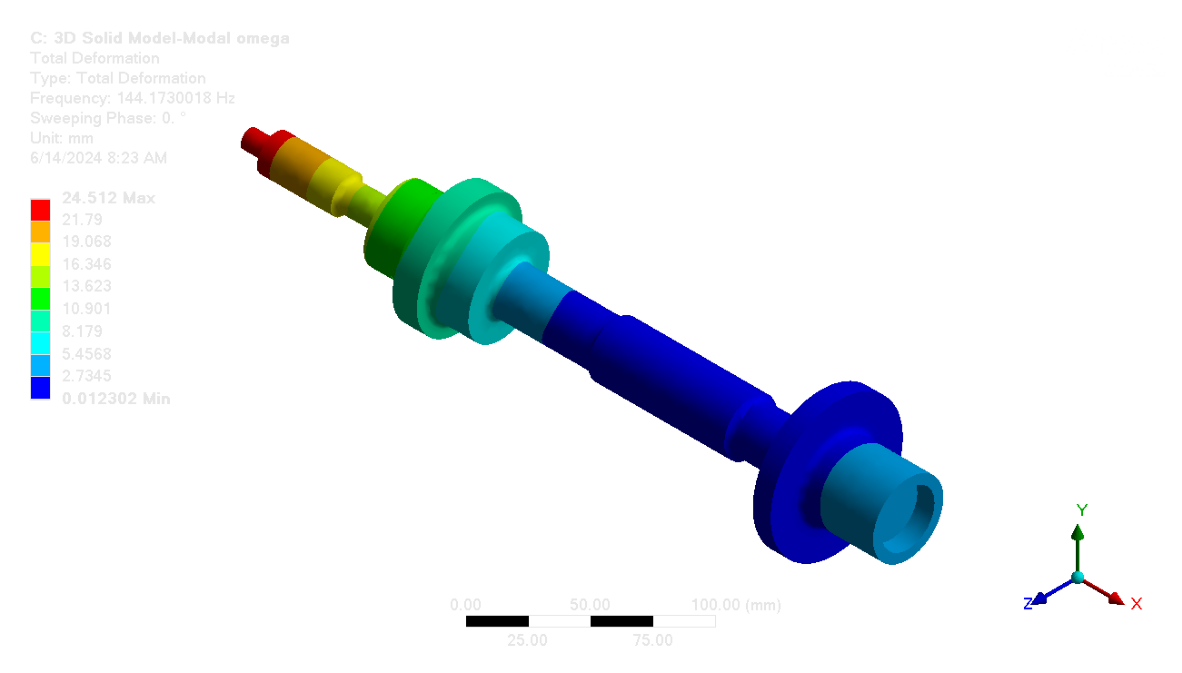

In [36]:
if image_path_server != "":
    current_working_directory = os.getcwd()

    local_file_path_list = mechanical.download(
        image_path_server, target_dir=current_working_directory
    )
    image_local_path = local_file_path_list[0]
    print(f"Local image path : {image_local_path}")
    
    display_image(image_local_path)

Specify the Mechanical directory for the Unbalance Response Analysis and fetch the working directory path.
Download the solver output file (`solve.out`) from the server to the client's current working directory and print its contents.

In [37]:
mechanical.run_python_script(f"solve_dir=ExtAPI.DataModel.AnalysisList[3].WorkingDir")
result_solve_dir_server = mechanical.run_python_script(f"solve_dir")
print(f"All solver files are stored on the server at: {result_solve_dir_server}")

All solver files are stored on the server at: C:\Users\ansys\AppData\Local\Temp\WB_ansys_11708_2\wbnew_files\dp0\SYS-3\MECH\


In [38]:
solve_out_path = os.path.join(result_solve_dir_server, "solve.out")

In [39]:
def write_file_contents_to_console(path):
    """Write file contents to console."""
    with open(path, "rt") as file:
        for line in file:
            print(line, end="")

In [40]:
current_working_directory = os.getcwd()
mechanical.download(solve_out_path, target_dir=current_working_directory)
solve_out_local_path = os.path.join(current_working_directory, "solve.out")
write_file_contents_to_console(solve_out_local_path)
os.remove(solve_out_local_path)


 Ansys Mechanical Enterprise                       


 *------------------------------------------------------------------*
 |                                                                  |
 |   W E L C O M E   T O   T H E   A N S Y S (R)  P R O G R A M     |
 |                                                                  |
 *------------------------------------------------------------------*




 ***************************************************************
 *         ANSYS MAPDL 2024 R1          LEGAL NOTICES          *
 ***************************************************************
 *                                                             *
 * Copyright 1971-2024 Ansys, Inc.  All rights reserved.       *
 * Unauthorized use, distribution or duplication is            *
 * prohibited.                                                 *
 *                                                             *
 * Ansys is a registered trademark of Ansys, Inc. or its       *
 * sub

Download all the files from the server to the current working directory for the 3D rotor model.
Verify the source path for the directory and copy all files from the server to the client.

In [41]:
import shutil
import glob

In [42]:
current_working_directory = os.getcwd()
target_dir2 = current_working_directory
print(f"Files to be copied from server path at: {target_dir2}")
print(f"All the solver files are stored on the server at: {result_solve_dir_server}")

Files to be copied from server path at: C:\Users\ansys\actions-runner\_work\pyworkbench-examples\pyworkbench-examples\pyworkbench-examples\doc\source\examples\axisymmetric-rotor
All the solver files are stored on the server at: C:\Users\ansys\AppData\Local\Temp\WB_ansys_11708_2\wbnew_files\dp0\SYS-3\MECH\


In [43]:
source_dir = result_solve_dir_server
destination_dir = target_dir2

In [44]:
for file in glob.glob(source_dir + '/*'):
    shutil.copy(file, destination_dir)

Finally, call the `exit` method on both the PyMechanical and Workbench clients to gracefully shut down the services.

In [45]:
mechanical.exit()
wb.exit()